# This notebook does Fourier analysis of p(t) from .wav sound files 
## Uses [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html)

In [1]:
# This magic line loads numpy, scipy, matplotlib. 
# add the word inline to put figures inline

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## y(x) is p(t) from a sound file...

In [52]:
!ls data

3B42RT_daily.2014.07.23.nc   processed.wav
Bzzt.m4a                     riddler_laugh.wav
Daily_clim_data_Auckland.csv soi_nino.csv
ISO_datetime.xls             sst_nino3.dat
NIWA_SOI.csv                 year_month_day.xlsx
SOI_time_series.xlsx


In [53]:
!open data/riddler_laugh.wav

In [17]:
# For audio input files (.wav format) 
from scipy.io import wavfile
samplerate,p = wavfile.read("data/riddler_laugh.wav")

y = detrend(p)/std(p); x=arange( len(y) )

print(samplerate, 'samples per second')
T = len(y)*1.0/samplerate
print('This clip is '+str(T)+' seconds')

11025 samples per second
This clip is 2.345215419501134 seconds


## Plot the series

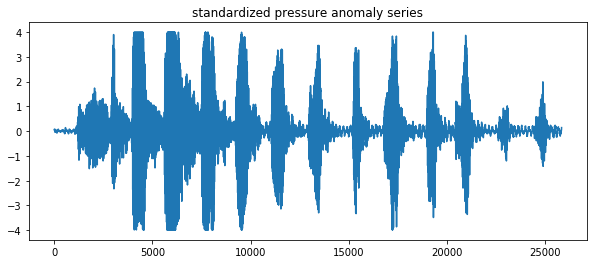

In [21]:
figsize(10,4)
plot(x,y, label='raw')
title('standardized pressure anomaly series');

Text(0.5,0,'Time [sec]')

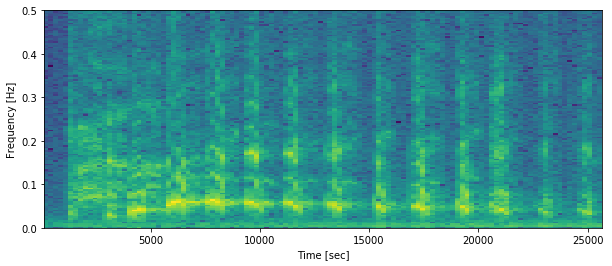

In [51]:
from scipy import signal 
f, t, Sxx = signal.spectrogram(y)
pcolormesh(t, f, np.log(Sxx))
ylabel('Frequency [Hz]')
xlabel('Time [sec]')

-------
# Below is all straight from Elementary_FFT_ notebook

## Make the complex spectrum, using fft
#### ...normalizing by input series length, since science doesn't want the *values* of spectra to depend on sampling rate (and thus N)

In [22]:
N = len(y) 
spec = fft.fft(y) /N

# Unpack in all the usual ways: real (cos) and imaginary (sin)
specr = real(spec)
speci = imag(spec)

# Unpack in all the usual ways: amplitude and phase
ampli = abs(spec)
phase = angle(spec)

### Tidy up the symmetry and labels for a nicer Power spectrum plot

In [24]:
# TAKE JUST THE LEFT HALF OF THE SYMMETRIC SPECTRUM
Frequencies = arange(N/2)   # cycles per time T
Frequencies = Frequencies/T # cycles per second (Hz) 

# BUT DOUBLE THE VALUEs other than 0
Amp2 = ampli[0:int(N/2)] *2.
Amp2[0] = 0

# Now power spectrum density is amplitude squared
Power = (Amp2**2) *0.5

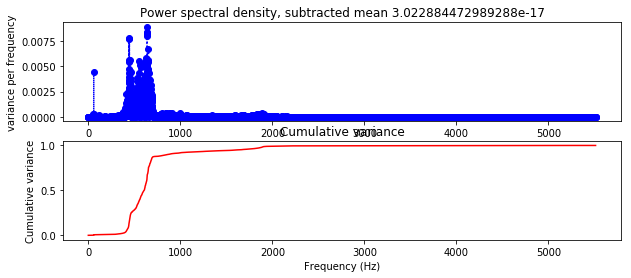

In [25]:
# Power spectral density plot
figure(4)
subplot(211)

plot(Frequencies,Power ,'bo')
plot(Frequencies,Power ,'b:')

title('Power spectral density, subtracted mean '+str(ampli[0]))
ylabel('variance per frequency');

subplot(212)
plot(Frequencies,cumsum(Power),'r')
title('Cumulative variance')
xlabel('Frequency (Hz)')
ylabel('Cumulative variance');

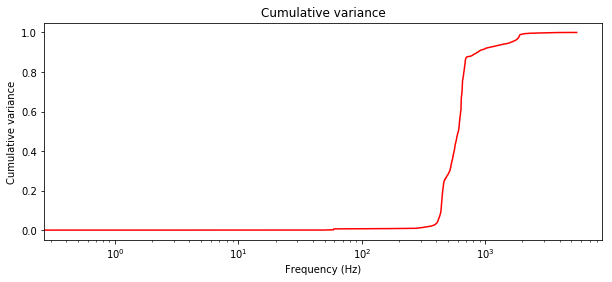

In [26]:
figure(5)
semilogx(Frequencies,cumsum(Power),'r')
title('Cumulative variance')
xlabel('Frequency (Hz)')
ylabel('Cumulative variance');

In [29]:
print(mean(y**2))
print(var(y))

1.0
1.0


---
How does it sound different if we mess with it? 

## Reconstruct (synthesize) data by meddling with phase. 
#### Notice that 1j is *i* in Python 

In [36]:
# Edit the spectrum's phase and amplitude:
syn_ampli = ampli

# Phase=0 gives the autocorrelation function
syn_phase = phase*0; explabel = 'phase =0'

# Phase = rand() makes synthetic data
#syn_phase = 2*pi*rand( len(phase) ); explabel = 'random phases'

### Build spectrum and invert, from edited amplitude and phase

In [37]:
# Build the synthetic spectrum from real and imaginary parts
syn_spec =(    syn_ampli*cos(syn_phase)   #real part
         + 1j* syn_ampli*sin(syn_phase) ) #imag part

# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# And there is a near-zero imaginary part; strip it off with real()
syn_data = real( ifft(syn_spec)*N )

### Display the synthetic data 

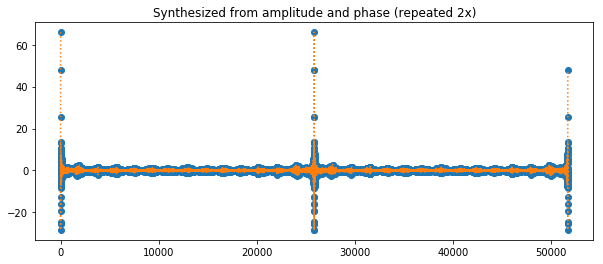

In [38]:
plot(tile(syn_data,2),'o')
plot(tile(syn_data,2),':')
title('Synthesized from amplitude and phase (repeated 2x)');

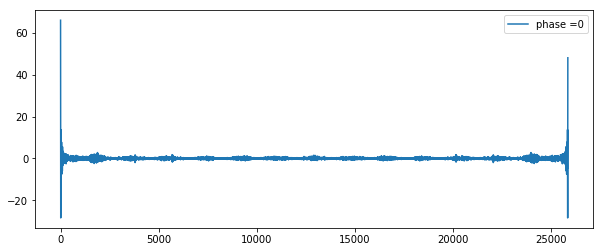

In [39]:
figure(1) # replot on top of the initial data plot (Fig. 1)
plot(x,syn_data, label=explabel)
legend(loc='best');

### Export synthetic data, how does it sound different?

In [41]:
wavfile.write("data/processed.wav", samplerate, syn_data)